# Install

In [1]:
# pip install opencv-python

# Imports

In [1]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Hough Line Transform

This notebook serves as a proof of concept that probabilistic hough transform lines are the way to go about detecting the yard lines. 

This version still struggles with consistently recognizing the line of scrimmage and first down markers on a football field. That is likely due to these lines being inconsistent in color from broadcast to broadcast, which then causes issues with edge detection, as by the time we've reached this step those lines are typically grayed or blurred into the same color as the grass.

Standard usually picks up on way too many lines.

For testing, cycle through the image numbers 0-4.

One other thing to note: different broadcasts have different heights for their score bar, which means we may need to do some sort of automatic detection to gray out the score bar. Although, the current standard seems to do a decent job thus far.

## Load Image

In [153]:
image_number = 1

In [154]:
# load image as gray scale
img = cv2.imread(f"./pre_snap_images/{image_number}.png")

## Convert to Grayscale

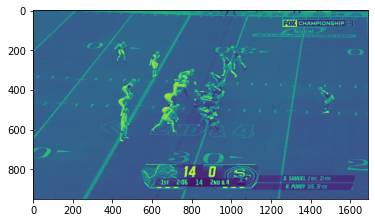

In [155]:
# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

## Masking Score Bar

`0.85` was the original `mask_height value used in tessting`. However, `0.81` appears to be more effective for blocking more diverse score bars, coming from different types of broadcasts.

In [170]:
mask_height = 0.81

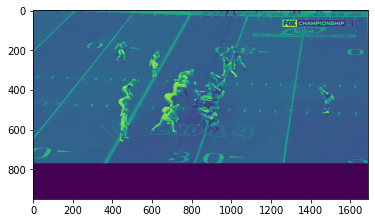

In [174]:
# masking score bar
mask_height = int(gray.shape[0] * mask_height)
mask = np.zeros(gray.shape, dtype=np.uint8)
cv2.rectangle(mask, (0, 0), (gray.shape[1], mask_height), (255), thickness=-1)

# Apply the mask to the grayscale image
masked_gray = cv2.bitwise_and(gray, mask)
plt.imshow(masked_gray)

## Edge Detection

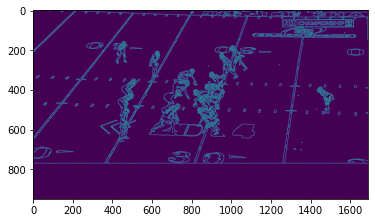

In [157]:
# edge detection
dst = cv2.Canny(masked_gray, 50, 200, None, 3)
plt.imshow(dst)

## Standard

In [158]:
# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

In [159]:
# standard hough line transform
lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)

with the following arguments:
- dst: Output of the edge detector. It should be a grayscale image (although in fact it is a binary one)
- lines: A vector that will store the parameters (r,θ) of the detected lines
- rho : The resolution of the parameter r in pixels. We use 1 pixel.
- theta: The resolution of the parameter θ in radians. We use 1 degree (CV_PI/180)
- threshold: The minimum number of intersections to "*detect*" a line
- srn and stn: Default parameters to zero. Check OpenCV reference for more info.


In [160]:
# draw lines
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        
        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)

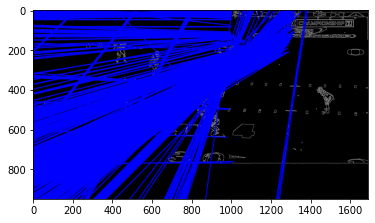

In [161]:
plt.imshow(cdst)

## Probabilistic

In [162]:
# Copy edges to the images that will display the results in BGR
cdstP = None
cdstP = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

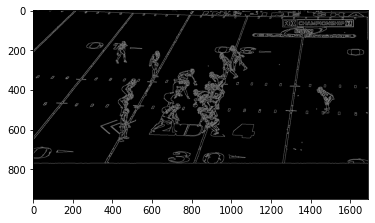

In [163]:
plt.imshow(cdstP)

In [164]:
# probabilistic hough transform
linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 90, 6)

# Specify a range of angles to consider as horizontal
angle_threshold_low = 85  # lower angle in degrees
angle_threshold_high = 95  # higher angle in degrees

if linesP is not None:
    print(f"Lines detect: {len(linesP)}")
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        
        # calculate the angle of the line
        line_angle = abs(np.arctan2(l[3] - l[1], l[2] - l[0]) * (180 / np.pi))

        # vertical field line angles
        vert_condition = line_angle >= 50 and line_angle <= 100
        
        # horizontal field line angles
        horiz_condition = line_angle <= 3
        
        # filter out lines that are noise
        if vert_condition or horiz_condition:
            cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

Lines detect: 48


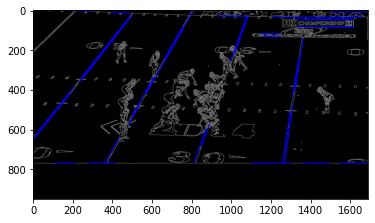

In [165]:
plt.imshow(cdstP)

## Extracting Field Lines

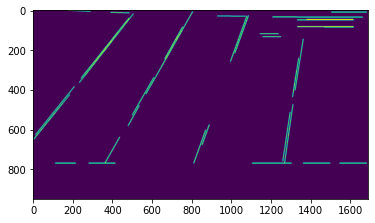

In [166]:
mask = cv2.inRange(cdstP, (0, 0, 255), (0, 0, 255))
plt.imshow(mask)

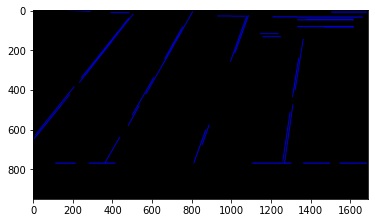

In [167]:
# Bitwise-AND mask and original image to extract desired color
extracted_image = cv2.bitwise_and(cdstP, cdstP, mask=mask)
plt.imshow(extracted_image)

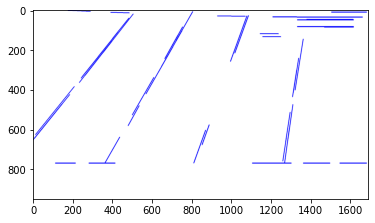

In [168]:
# First, invert the mask: where the mask is black, we make it white, and vice versa
inverse_mask = cv2.bitwise_not(mask)

# Now create a white image of the same size as the extracted_image
white_background = np.ones_like(extracted_image) * 255

# Use the inverse mask to change the black background of the extracted_image to white
extracted_image[inverse_mask == 255] = white_background[inverse_mask == 255]

# Now extracted_image should have white background with the colored lines
# Display the image with the white background
plt.imshow(extracted_image)  # Convert BGR to RGB for displaying in matplotlib

# Saving Sample

In [142]:
cv2.imwrite(f"./detection_samples/{image_number}-cdstP.jpg", cdstP)
cv2.imwrite(f"./detection_samples/{image_number}-extracted.jpg", extracted_image)
cv2.imwrite(f"./detection_samples/{image_number}-original.jpg", cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

True

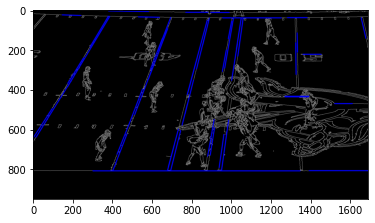

In [143]:
plt.imshow(cdstP)

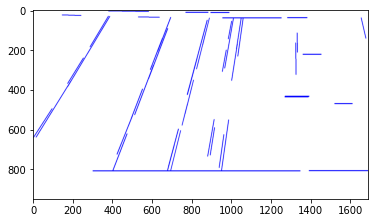

In [144]:
plt.imshow(extracted_image)

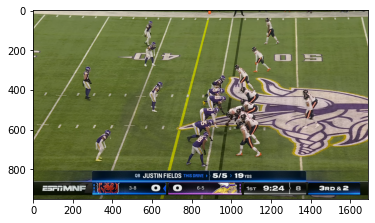

In [145]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Comparison Trials

### Unmasked Score Bar - Standard:

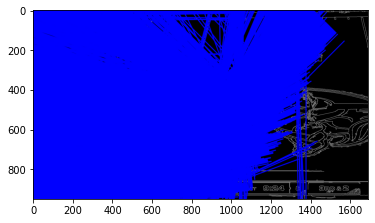

In [23]:
plt.imshow(cdst)

### Masked Score Bar - Standard:

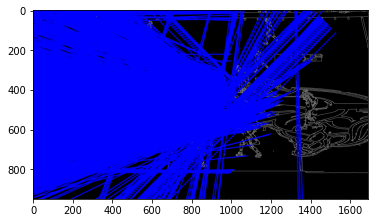

In [13]:
plt.imshow(cdst)

### Masked Score Bar - Probabilistic:

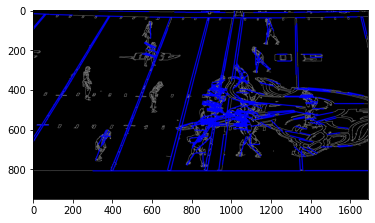

In [14]:
plt.imshow(cdstP)

## Field Lines Extracted From IMG

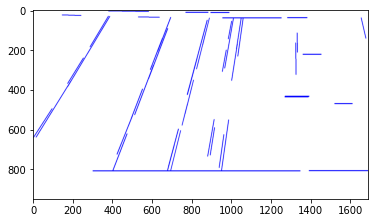

In [303]:
plt.imshow(extracted_image) 

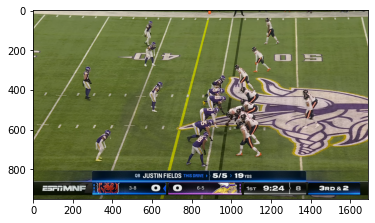

In [304]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))